# CID-Net for ultrasound images reconstruction from I/Q signals

In [1]:
import numpy as np
import h5py
import onnxruntime as onnxrt
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Functions

In [2]:
def load_h5(filename,mode='r'):
    with h5py.File(filename,mode) as f:
        data = f['data'][:]
    return data
def bmode(IQ, DR):
    assert (DR > 0), 'The dynamic range DR in dB must be > 0.'
    I = np.abs(IQ)
    I = 20*np.log10(I/np.max(I)) + DR
    I[np.where(I < 0)] = 0
    I = (255*I/DR).astype('uint8')
    return I
def display(grid_x, grid_z, image, title):
    plt.pcolormesh(grid_x, grid_z, image, cmap='Greys_r',shading='gouraud')
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.title(title,fontsize=16)
    plt.show()
def inference(model, inputs):
    inputs = np.expand_dims(inputs, axis=0)
    model = onnxrt.InferenceSession(model)
    inputs = {model.get_inputs()[0].name:inputs.real,
              model.get_inputs()[1].name:inputs.imag}
    outputs = model.run(None, inputs)
    outputs = outputs[0][0, 0, :, :] + 1j*outputs[1][0, 0, :, :]
    return outputs

## Image grids

In [3]:
grid_z = load_h5('data/grid_z.h5')
grid_x = load_h5('data/grid_x.h5')

## Phantom data (Gammex, model 410SCG)
### Standard compounding

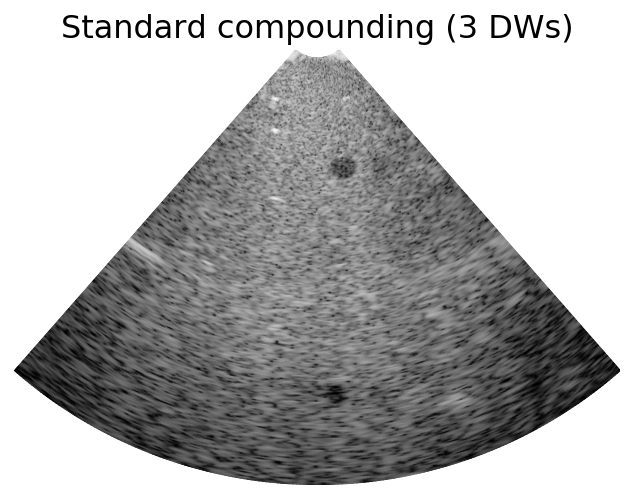

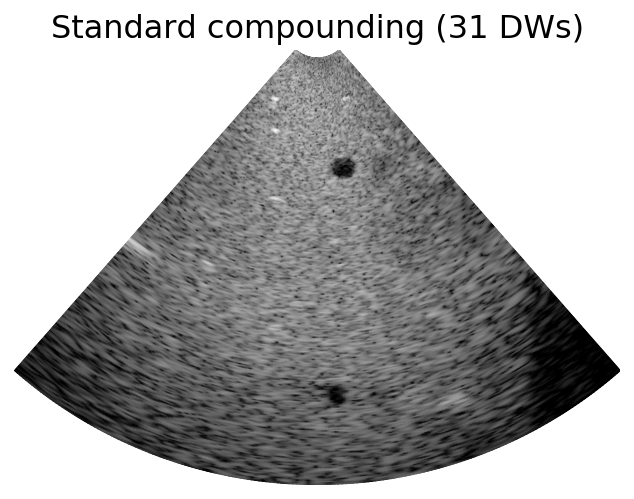

In [4]:
IQ = load_h5('data/data_gammex.h5')
IQ_31_DW = np.mean(IQ, axis=0) # compounding 31 steering angles from -30 to 30 degree
IQ_03_DW = np.mean(IQ[[5,15,25]], axis=0) # compounding 3 steering angles at -20, 0, 20 degree
BMode_03_DW = bmode(IQ_03_DW, 60)
BMode_31_DW = bmode(IQ_31_DW, 60)
display(grid_x, grid_z, BMode_03_DW, 'Standard compounding (3 DWs)')
display(grid_x, grid_z, BMode_31_DW, 'Standard compounding (31 DWs)')

### Inference using CID-Net

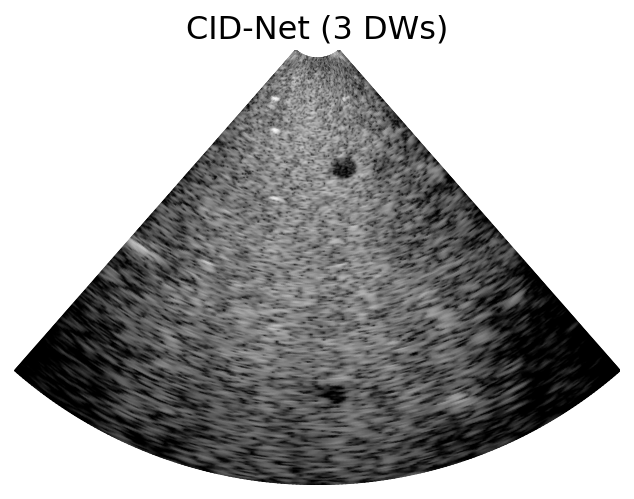

In [5]:
model = 'model/cid_net.onnx'
IQ_CIDNET = inference(model, IQ[[5,15,25]]) # CID-Net reconstruction using 3 steering angless
BMode_CIDNet = bmode(IQ_CIDNET, DR=60)
display(grid_x, grid_z, BMode_CIDNet, 'CID-Net (3 DWs)')

## Phantom data (CIRS, model 054GS)
### Standard compounding

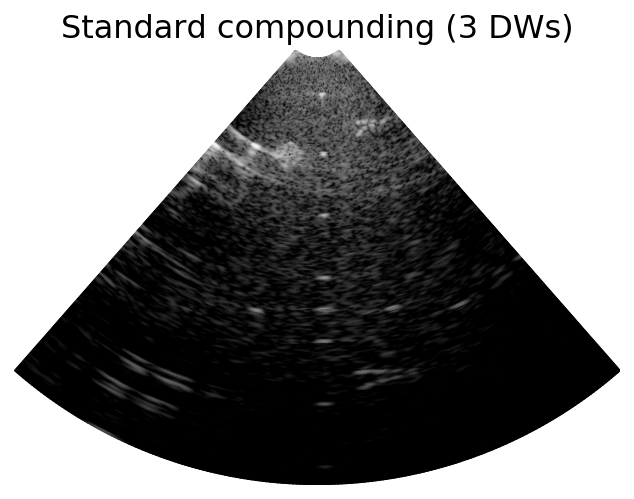

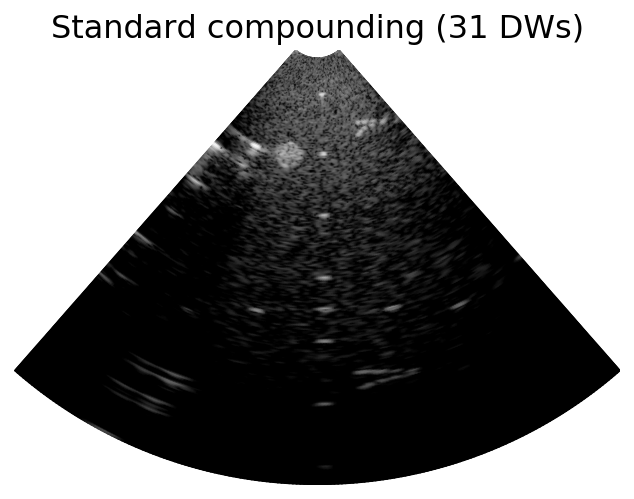

In [6]:
model = 'model/cid_net.onnx'
IQ = load_h5('data/data_cirs.h5')
IQ_31_DW = np.mean(IQ, axis=0)
IQ_03_DW = np.mean(IQ[[5,15,25]], axis=0)
BMode_03_DW = bmode(IQ_03_DW, 60)
BMode_31_DW = bmode(IQ_31_DW, 60)
display(grid_x, grid_z, BMode_03_DW, 'Standard compounding (3 DWs)')
display(grid_x, grid_z, BMode_31_DW, 'Standard compounding (31 DWs)')

### Inference using CID-Net

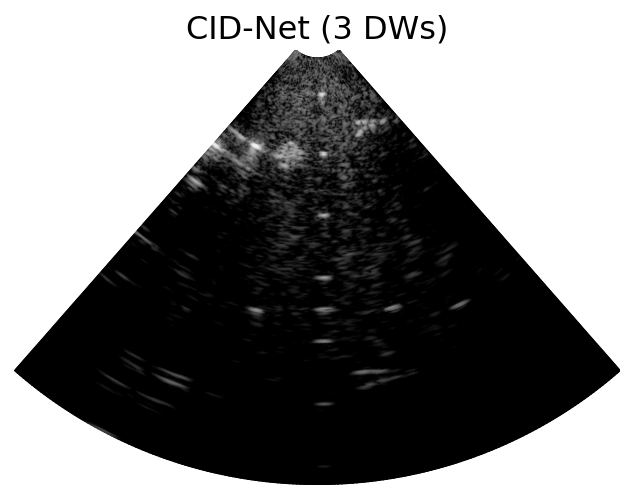

In [7]:
IQ_CIDNET = inference(model, IQ[[5,15,25]])
BMode_CIDNet = bmode(IQ_CIDNET, DR=60)
display(grid_x, grid_z, BMode_CIDNet, 'CID-Net (3 DWs)')